In [1]:
import numpy as np
from numpy.random import default_rng
from copy import copy

# visualize
import arviz
import matplotlib.pyplot as plt

# 初回インストール時実行
# import cmdstanpy
# cmdstanpy.install_cmdstan()
from cmdstanpy import CmdStanModel

# random generator
rg = default_rng(123)

## Censored Regression (切り捨て回帰)

以下の式を実装する

$$y_i^\ast = intercept + slope \times x_i + \epsilon \quad \epsilon \sim N(0, \sigma)$$

ただし、事前分布は以下のように設定される。
- $intercept \sim N(0, 1)$
- $slope \sim N(0, 1)$
- $sigma \sim HalfNorm(0, 1)$

$$
y_i =
    \begin{cases}
        c_l        &   \text{$y_i^\ast > c_l$のとき} \\
        c_u        &   \text{$y_i^\ast < c_u$のとき} \\
        y_i^\ast   &   \text{その他}
    \end{cases}
$$

In [2]:
# parameters
slope, intercept, sigma, N, bounds = 1, 0, 2, 1500, [-5, 5]

# data generating
x = rg.uniform(-10, 10, N).reshape(N, -1)
y = rg.normal(loc=np.dot(x, slope).reshape(-1) + intercept, scale=sigma)


def censor_y(x, y, bounds):
    cy = copy(y)
    cy[y <= bounds[0]] = bounds[0]
    cy[y >= bounds[1]] = bounds[1]
    return (x, cy)


xt, yt = censor_y(x, y, bounds)

[Text(0.5, 1.0, 'censored data')]

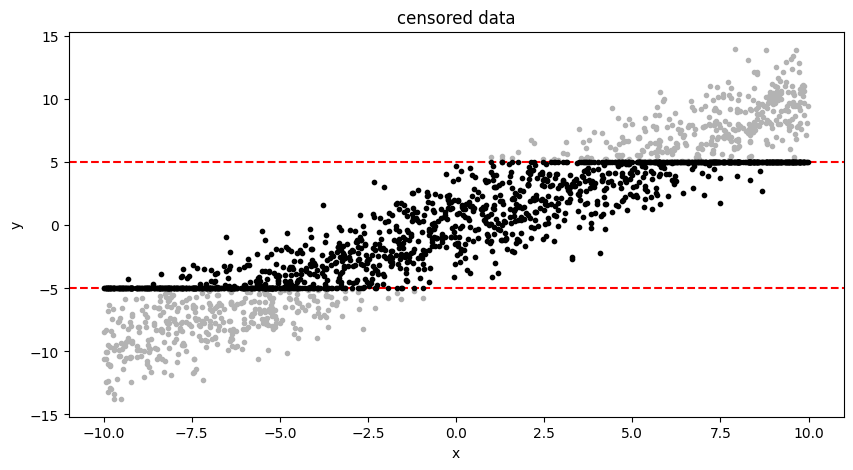

In [3]:
# プロット
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, y, ".", c=[0.7, 0.7, 0.7])
ax.axhline(bounds[0], c="r", ls="--")
ax.axhline(bounds[1], c="r", ls="--")
ax.set(xlabel="x", ylabel="y")
ax.plot(xt, yt, ".", c=[0, 0, 0])
ax.set(title="censored data")

# Pytanによる実装

In [4]:
# モデル読み込み
model = CmdStanModel(stan_file="../src/stan/censored_regression.stan")

# モデル式
print("-------------------")
model.format()

-------------------
data {
  // num of data
  int<lower=0> N_obs;
  int<lower=0> N_cens_upper;
  int<lower=0> N_cens_lower;
  int<lower=0> n_dim;
  
  // observation data
  vector[N_obs] y_obs;
  matrix[N_obs, n_dim] X_obs;
  matrix[N_cens_upper, n_dim] X_cens_upper;
  matrix[N_cens_lower, n_dim] X_cens_lower;
  
  // settings
  real<lower=max(y_obs)> upper_bound;
  real<upper=min(y_obs)> lower_bound;
}
parameters {
  vector[n_dim] beta;
  real<lower=0> sigma;
  vector<lower=upper_bound>[N_cens_upper] y_cens_upper;
  vector<upper=lower_bound>[N_cens_lower] y_cens_lower;
}
model {
  y_obs ~ normal(X_obs * beta, sigma);
  y_cens_upper ~ normal(X_cens_upper * beta, sigma);
  y_cens_lower ~ normal(X_cens_lower * beta, sigma);
}




In [5]:
# Data dict for stan
stan_data = {
    "N_obs": len(yt[(yt < 5) & (yt > -5)]),
    "N_cens_upper": len(yt[yt == 5]),
    "N_cens_lower": len(yt[yt == -5]),
    "n_dim": xt.shape[1],
    "y_obs": yt[(yt < 5) & (yt > -5)],
    "X_obs": xt[(yt < 5) & (yt > -5)],
    "X_cens_upper": xt[yt == 5],
    "X_cens_lower": xt[yt == -5],
    "upper_bound": 5,
    "lower_bound": -5,
}

# 計算
res = model.sample(
    data=stan_data,
    iter_warmup=1500,
    iter_sampling=500,
    parallel_chains=4,
    chains=4,
)

18:07:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:07:36 - cmdstanpy - INFO - CmdStan done processing.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'y_cens_upper'}>,
        <Axes: title={'center': 'y_cens_upper'}>],
       [<Axes: title={'center': 'y_cens_lower'}>,
        <Axes: title={'center': 'y_cens_lower'}>]], dtype=object)

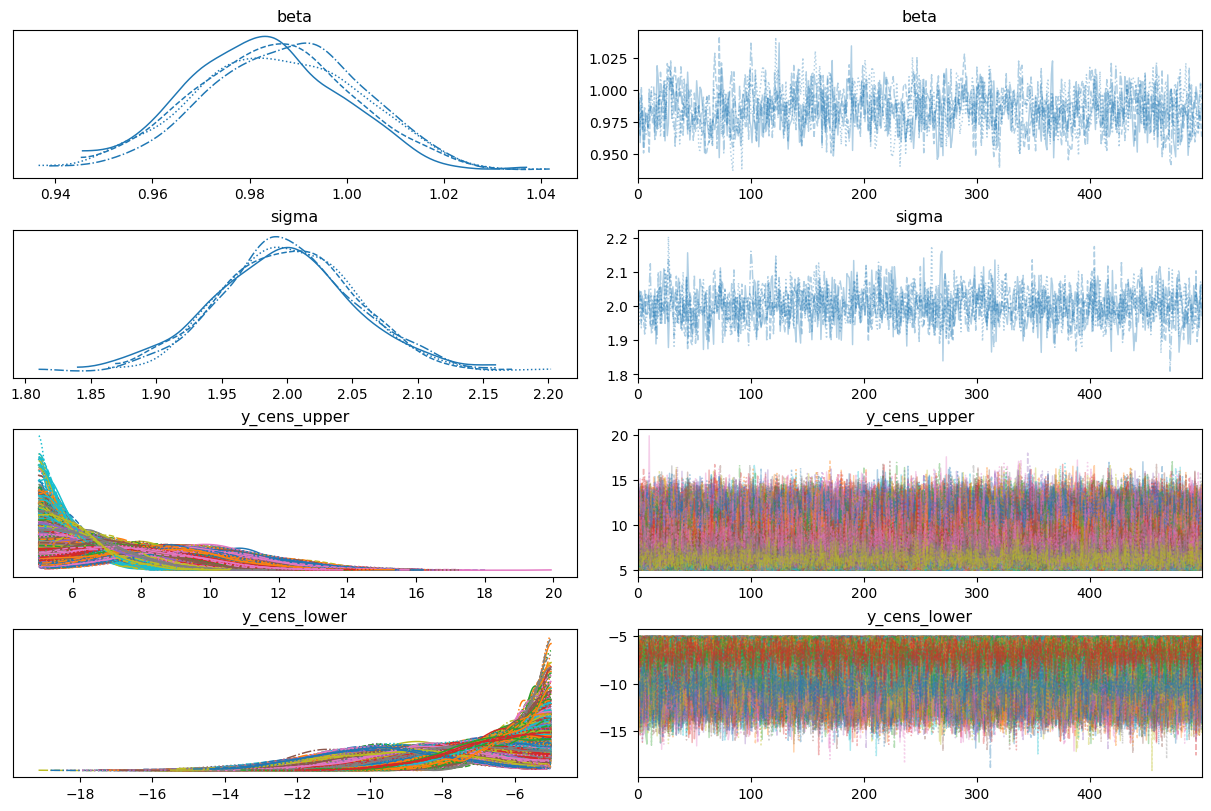

In [6]:
arviz.plot_trace(res, backend_kwargs={"constrained_layout": True})

In [7]:
res.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-1313.530000,1.598150,28.449700,-1359.710000,-1312.620000,-1267.21000,316.90000,104.96800,1.008630
beta[1],0.985109,0.000649,0.016239,0.958323,0.985074,1.01189,626.22100,207.42700,1.006090
sigma,2.000150,0.001320,0.051330,1.916600,1.998750,2.08720,1510.19093,500.22886,1.000270
y_cens_upper[1],8.557120,0.038914,1.814980,5.713790,8.425160,11.71590,2175.39000,720.56500,1.000120
y_cens_upper[2],7.143960,0.032547,1.464970,5.214510,6.884730,9.89021,2025.93000,671.06000,0.999018
...,...,...,...,...,...,...,...,...,...
y_cens_lower[360],-6.536730,0.020296,1.212120,-8.991170,-6.284120,-5.11667,3566.62000,1181.39000,0.998881
y_cens_lower[361],-9.733760,0.038545,1.785340,-12.678500,-9.720050,-6.76008,2145.44000,710.64600,1.001300
y_cens_lower[362],-6.132380,0.016362,0.967587,-8.112580,-5.906240,-5.06123,3496.98000,1158.32000,0.999222
y_cens_lower[363],-6.764660,0.025869,1.298390,-9.155190,-6.548660,-5.11971,2519.08000,834.41000,0.998989
